# Exploratory Data Analisys
First, we will start doing some exploratory analisys and visualitation over the data.
EDA will help us know and understand our data.

In [118]:
import pandas as pd
import numpy as np
import math
from numpy import nan
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
import wget
url="http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
wget.download(url) 

'household_power_consumption (1).zip'

In [3]:
import zipfile
with zipfile.ZipFile("household_power_consumption.zip", "r") as zf:
    zf.extractall()

# Data Cleansing
fill_missing() replaces NaN values for the value of the previous day

In [119]:
def fill_missing(values):
    one_day =  24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [120]:
power_consumption=pd.read_csv('household_power_consumption.txt',sep=';',low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]},index_col=['datetime'])
power_consumption=power_consumption[['Global_active_power']]
power_consumption.replace('?', nan, inplace=True)
power_consumption['Global_active_power'] = power_consumption['Global_active_power'].astype(float)
fill_missing(power_consumption.values)
power_consumption['Global_active_power'] = power_consumption['Global_active_power'].apply(lambda x: x/60)
power_consumption=power_consumption.resample('h').sum()
power_consumption.rename(columns={"Global_active_power":"Active_Energy"},inplace=True)

In [121]:
power_consumption.describe()

,Active_Energy
count,34589.000000
mean,1.088698
std,0.894659
min,0.046733
25%,0.342033
50%,0.804367
75%,1.574967
max,6.560533


# Data Visualitation

Naturally, the first thing we do is plot the time series.

<AxesSubplot:xlabel='datetime', ylabel='Active_Energy'>

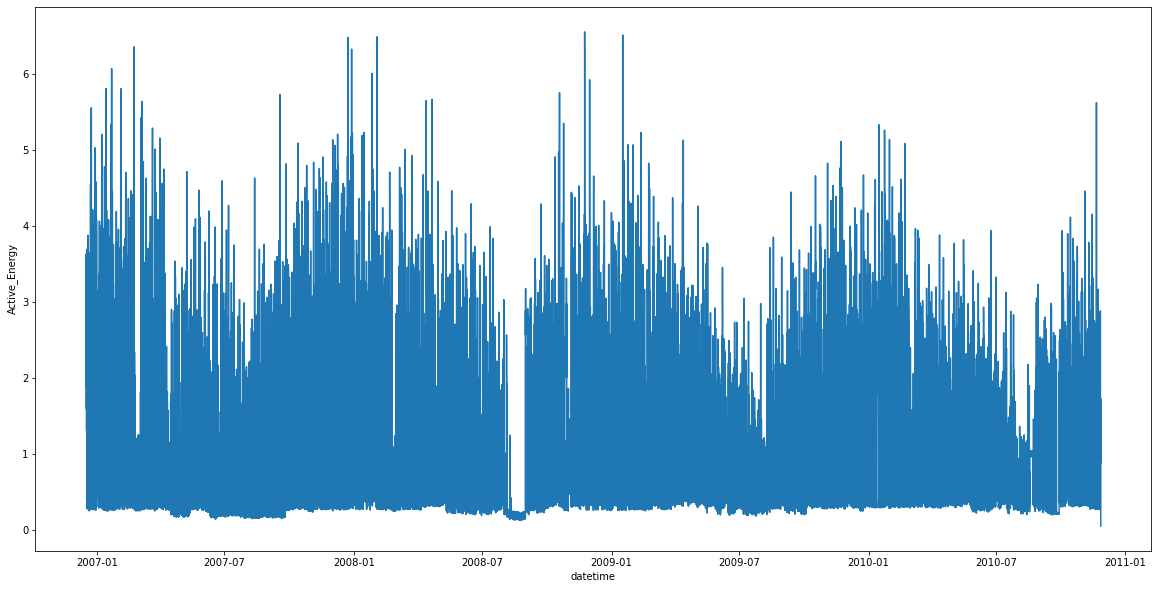

In [74]:
sns.lineplot(x=power_consumption.index,y='Active_Energy',data=power_consumption)

<AxesSubplot:xlabel='datetime'>

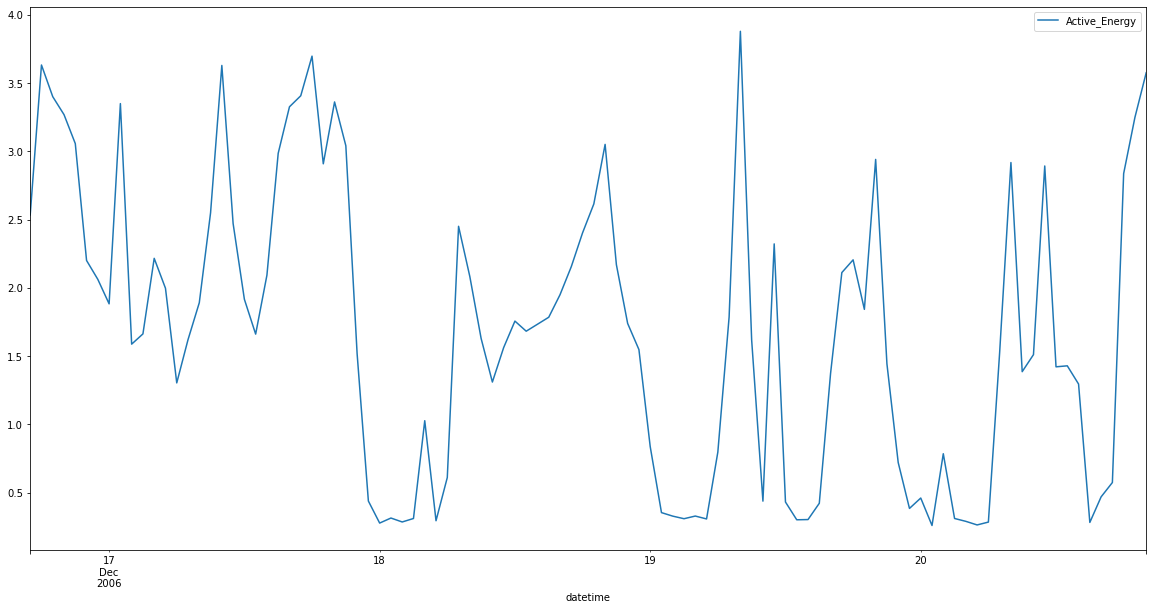

In [75]:
cut=100
zoom_data=power_consumption[:cut]
zoom_data.plot()

Then, we plot the histogram to get an idea of how our data is distributed.

array([[<AxesSubplot:title={'center':'Active_Energy'}>]], dtype=object)

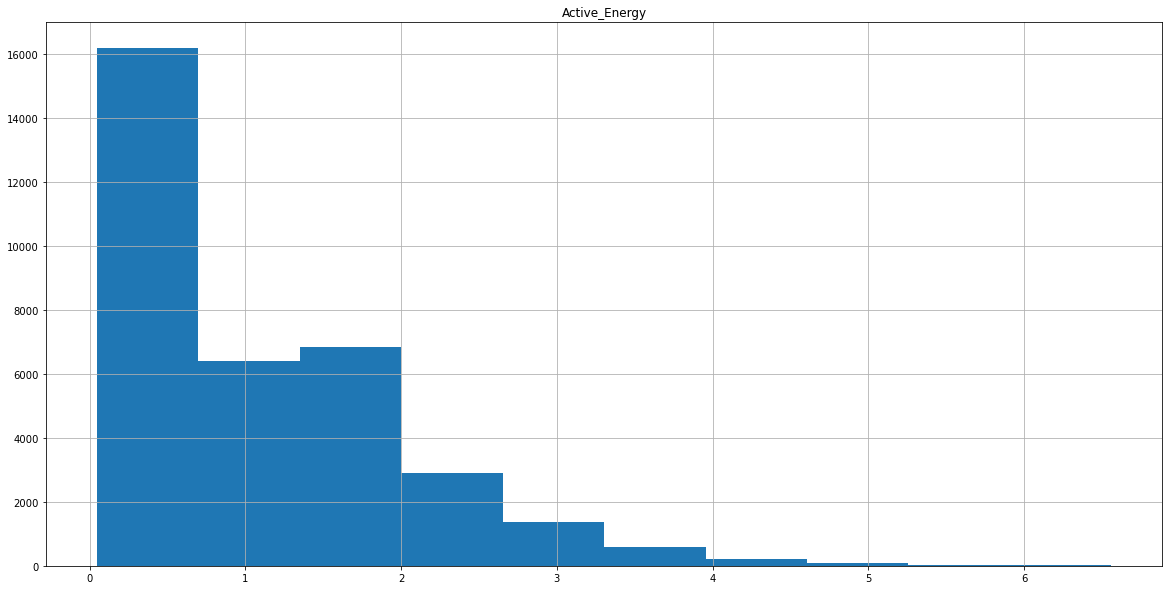

In [76]:
power_consumption.hist(column='Active_Energy')

Now, we descompose the time series into: trend, seasonal and residual components.
We don't see a notorius increasing trend, so we can suposse that an additive model will be better than a multiplicative one.
One the other hand, we can see a sort of seasonality with 8760 frequency (1 year)

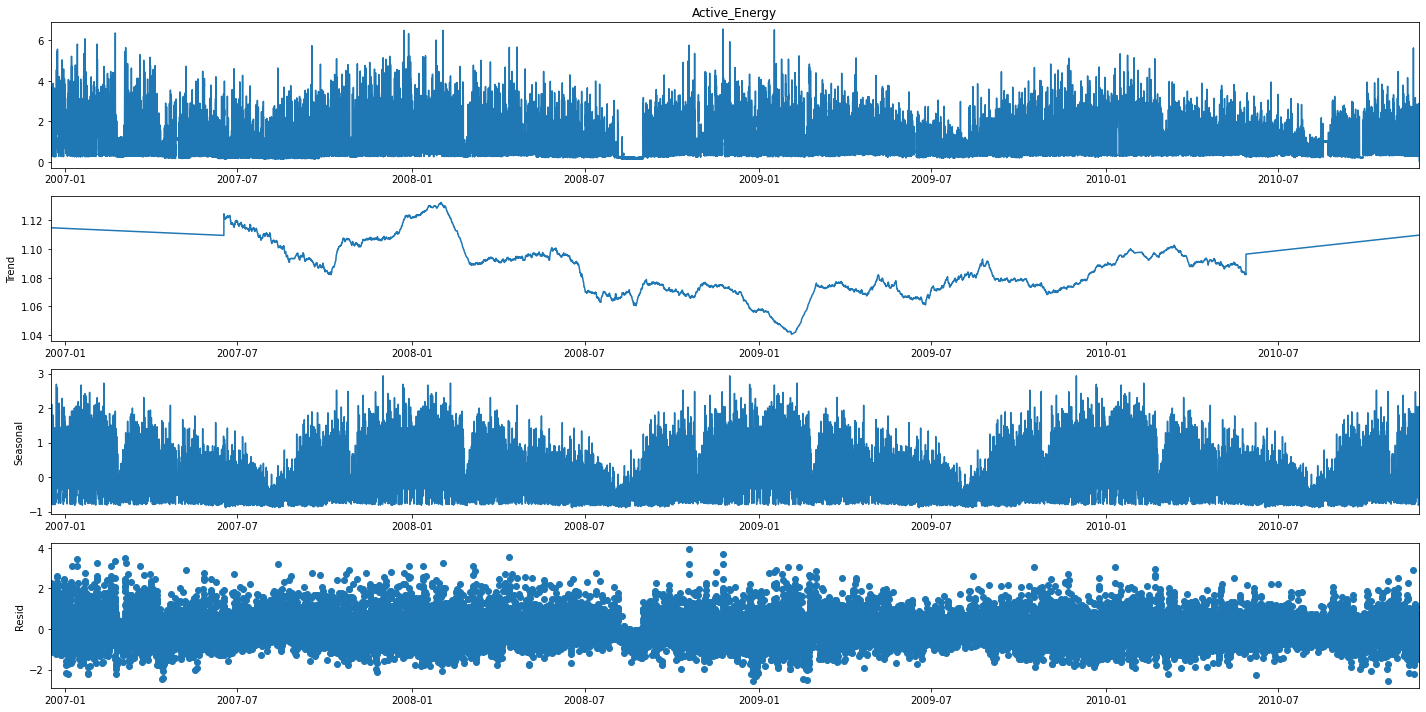

In [77]:
decomposition = seasonal_decompose(power_consumption['Active_Energy'], model='additive',period=8760, extrapolate_trend='freq')
decomposition.plot()
pyplot.show()

We can appreciatte that there is no significant trend variations. Also, we can see that the seasonal component changes a long the time, following a seasonal pattern , which may mean there is more than one seasonal pattern.

Now, we will plot the data changing the time series sampling frequency.

<AxesSubplot:xlabel='datetime', ylabel='Active_Energy'>

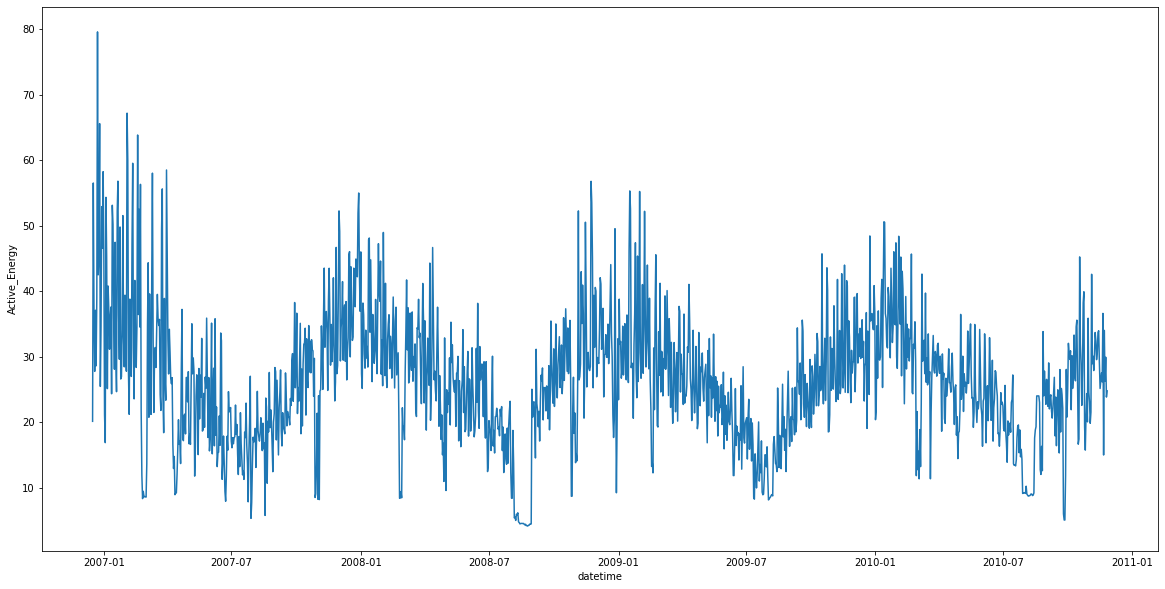

In [78]:
df_by_day=power_consumption.resample('D').sum()
sns.lineplot(x=df_by_day.index,y='Active_Energy',data=df_by_day)

<AxesSubplot:xlabel='datetime', ylabel='Active_Energy'>

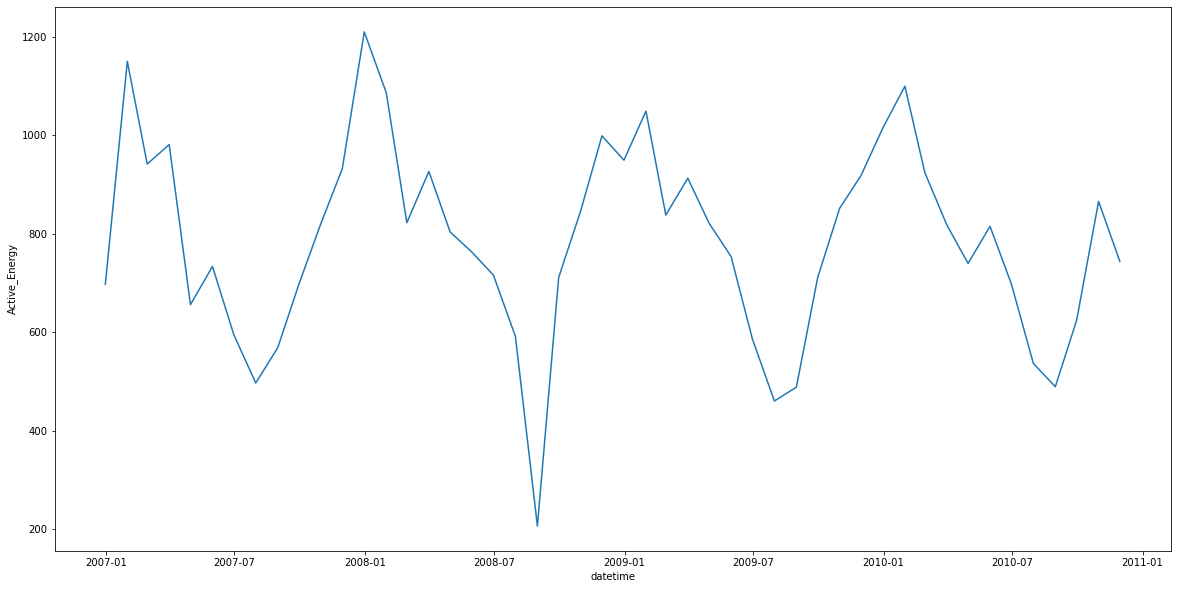

In [79]:
df_by_month=power_consumption.resample('M').sum()
sns.lineplot(x=df_by_month.index,y='Active_Energy',data=df_by_month)

As expected, we can see a seasonal yearly pattern.

Now, we are going to plot the average energy consumption by hour and month.

<AxesSubplot:xlabel='Hour', ylabel='Active_Energy'>

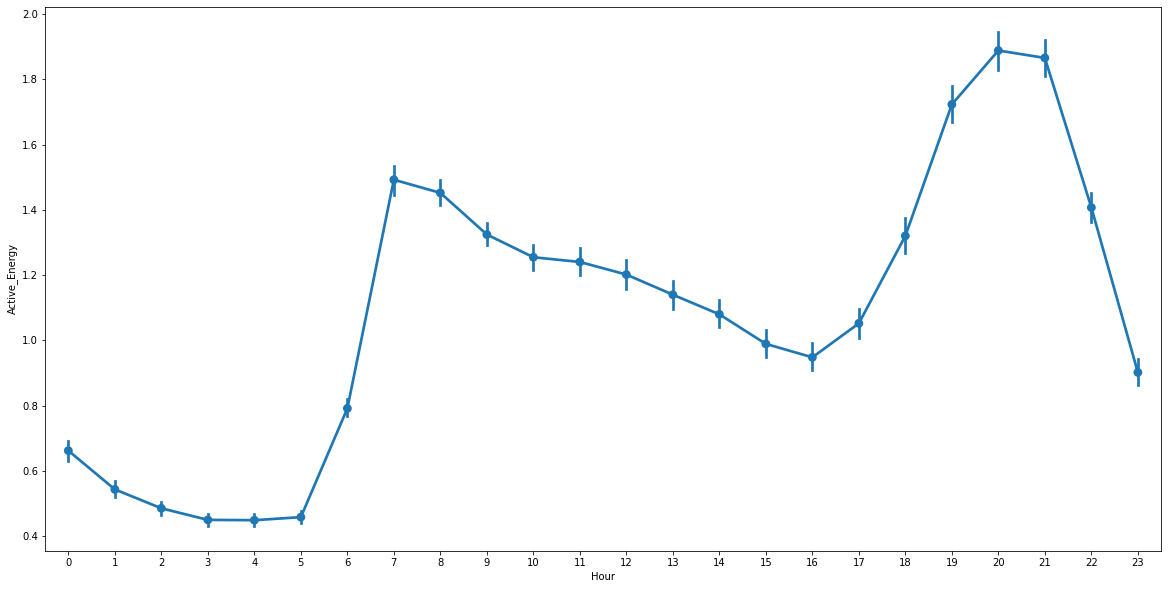

In [80]:
plot_for_power_consumption=power_consumption.copy()
plot_for_power_consumption['Hour']=plot_for_power_consumption.index.hour
plot_for_power_consumption['Month']=plot_for_power_consumption.index.month
sns.pointplot(data=plot_for_power_consumption,x='Hour',y='Active_Energy')

We can appreciate another seasonal pattern, but in that case is a dailly pattern.

<AxesSubplot:xlabel='Month', ylabel='Active_Energy'>

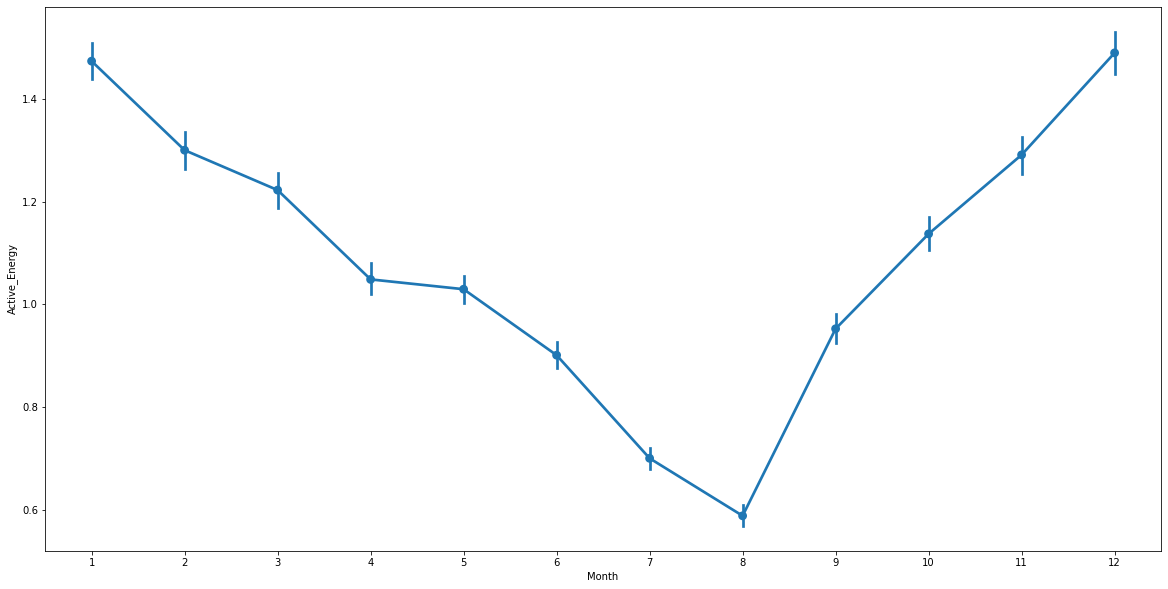

In [81]:
sns.pointplot(data=plot_for_power_consumption,x='Month',y='Active_Energy')

That plot reaffirm what we have previously seen, there is yearly pattern.

# Checking Stationarity

In [82]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

To say that a time series is stationari, the time series must not change his statical properties (mean, variance, covariance) along the time.
During the data visualitation we apreciate a clearly seasonal behaviour and presence of seasonality makes the time series non-stationary.
But eyeballing is not always reliable, for that reason we are going to check the stationarity applying statistical tests (ADFuller and KPSS)

In [83]:
def ADFuller(series, **kw):
    result = adfuller(series,autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

In [84]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [85]:
ADFuller(power_consumption['Active_Energy'])

ADF Statistic: -14.283024866475639
p-value: 1.3141026438731537e-26
Critial Values:
   1%, -3.4305393559398922
Critial Values:
   5%, -2.8616236906108443
Critial Values:
   10%, -2.566814545887977
Result: The series is stationary


In [86]:
kpss_test(power_consumption['Active_Energy'])

KPSS Statistic: 1.4129619810621572
p-value: 0.01
num lags: 52
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\Amin y Lubna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Amin y Lubna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


As we can apreciate, something interesting is happening. The KPSS test, reafirms but we had inferred from the EDA, the time series is not stationary. But the ADFuller reject the null hypothesis which indicates our series is stationary.
As a rule of thumb, when KPSS indicates non-stationarity and the ADF indicates stationarity, we can assume the series is difference stationary.

We will use the Box-Jenkins approach to make our series stationary. We will differenciate untill we get a stationary time series.

<AxesSubplot:xlabel='datetime'>

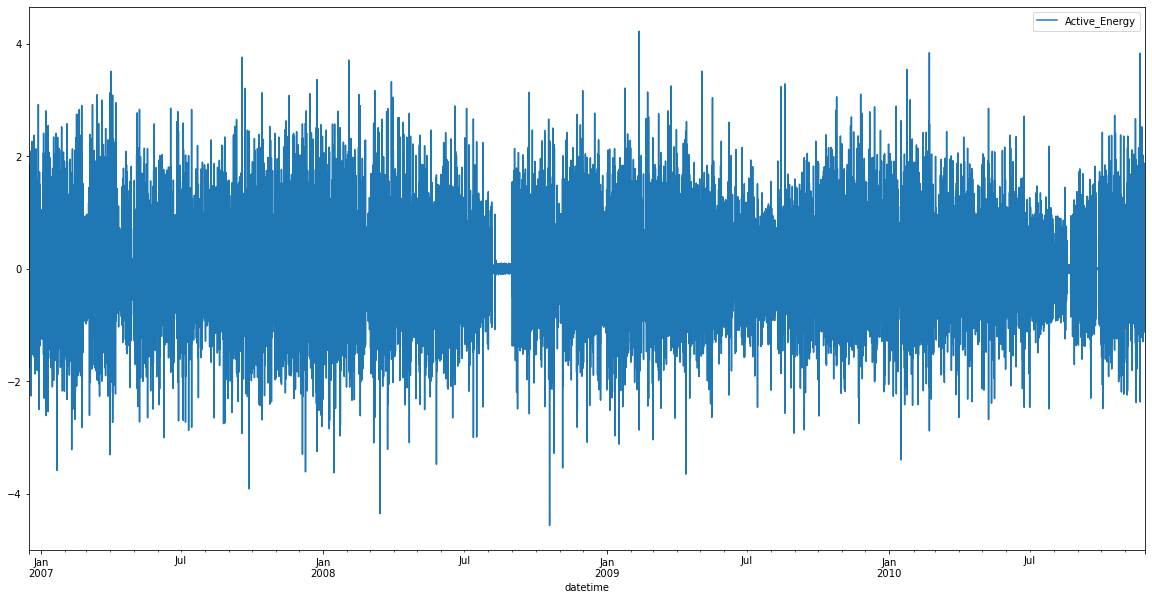

In [87]:
diff_1_series=power_consumption.copy()
data_for_reconstruction=diff_1_series[:1]
diff_1_series=diff_1_series.diff(1)
diff_1_series=diff_1_series.dropna()
diff_1_series.plot()

As we can see on the plot, after one diferentiation the series look stationary.

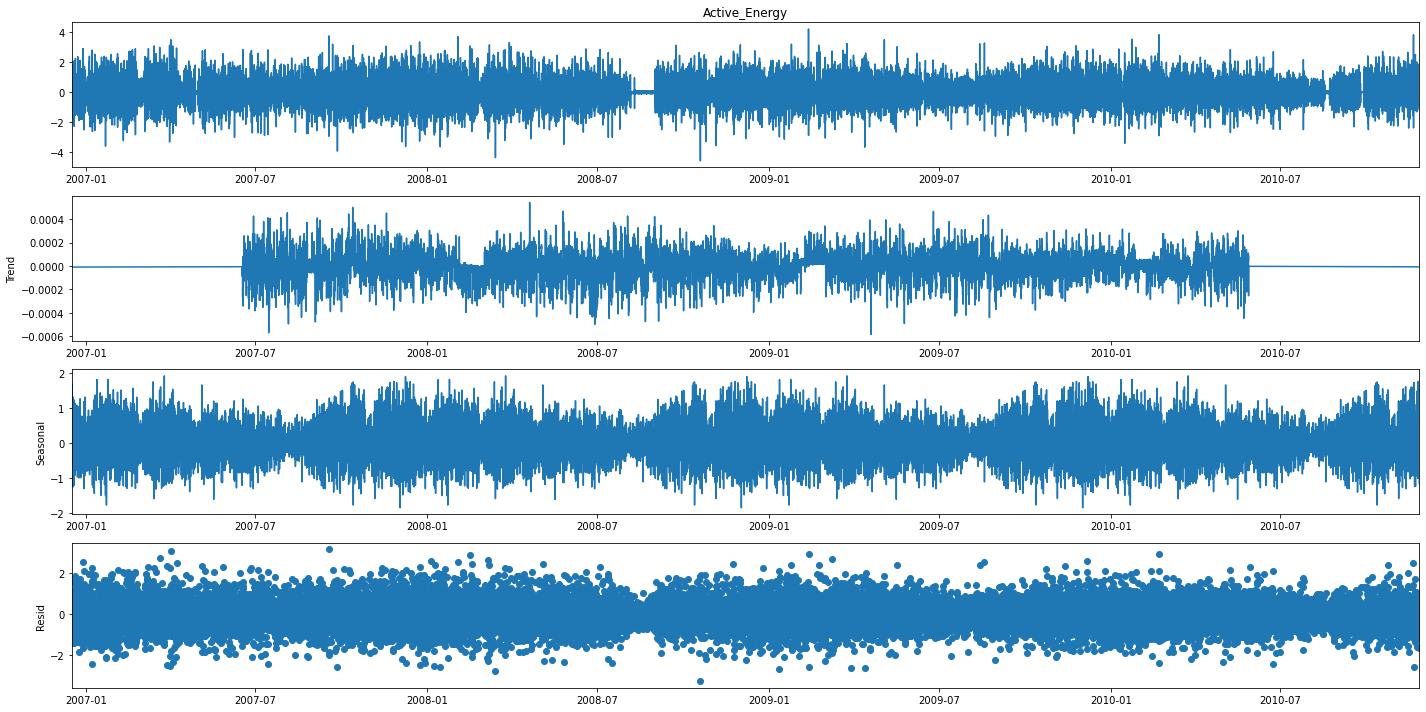

In [88]:
decomposition = seasonal_decompose(diff_1_series['Active_Energy'], model='additive',period=8760, extrapolate_trend='freq')
decomposition.plot()
pyplot.show()

On the seasonal decompose, we can appreciate that trend has almost dissapear and that we still have a important seasonal component.

We run the statistical test again.

In [89]:
ADFuller(diff_1_series['Active_Energy'])

ADF Statistic: -42.85874101908537
p-value: 0.0
Critial Values:
   1%, -3.4305393504569457
Critial Values:
   5%, -2.8616236881875956
Critial Values:
   10%, -2.5668145445981443
Result: The series is stationary


In [90]:
kpss_test(diff_1_series['Active_Energy'])

KPSS Statistic: 0.001215883064587735
p-value: 0.1
num lags: 52
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\Amin y Lubna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Amin y Lubna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


Now, we can see that after one differenctiation both test indicates that the diferentiated timer series is stationary,
eventhouhg visually we can still apretiate some sort of seasonality

<AxesSubplot:xlabel='datetime'>

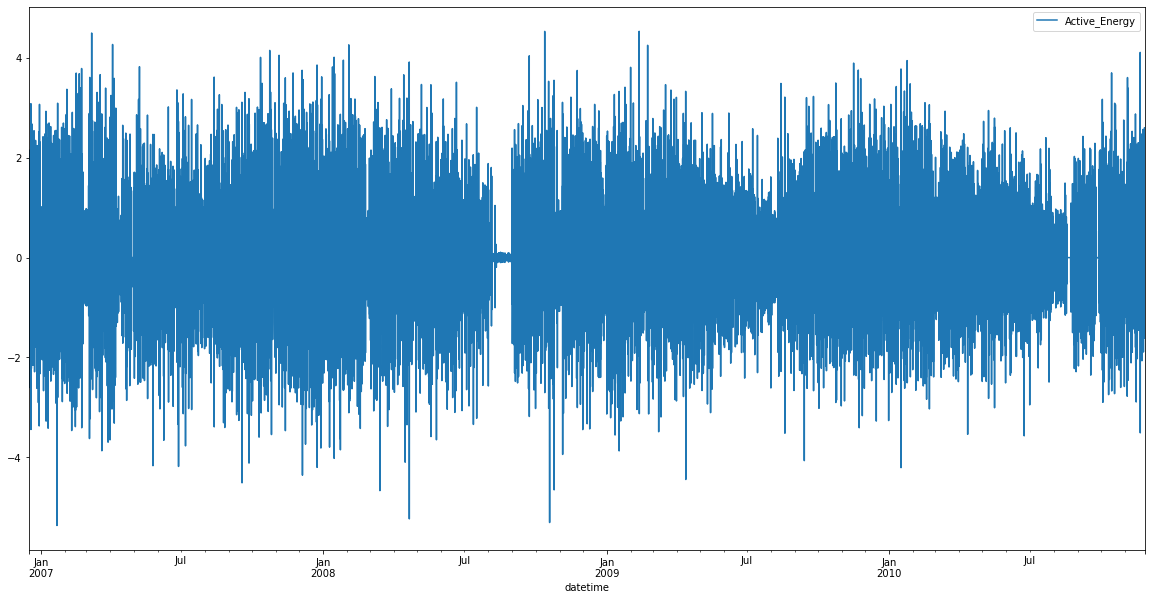

In [91]:
diff_2_series=power_consumption.copy()
data_for_reconstruction=diff_2_series[:2]
diff_2_series=diff_2_series.diff(2)
diff_2_series=diff_2_series.dropna()
diff_2_series.plot()

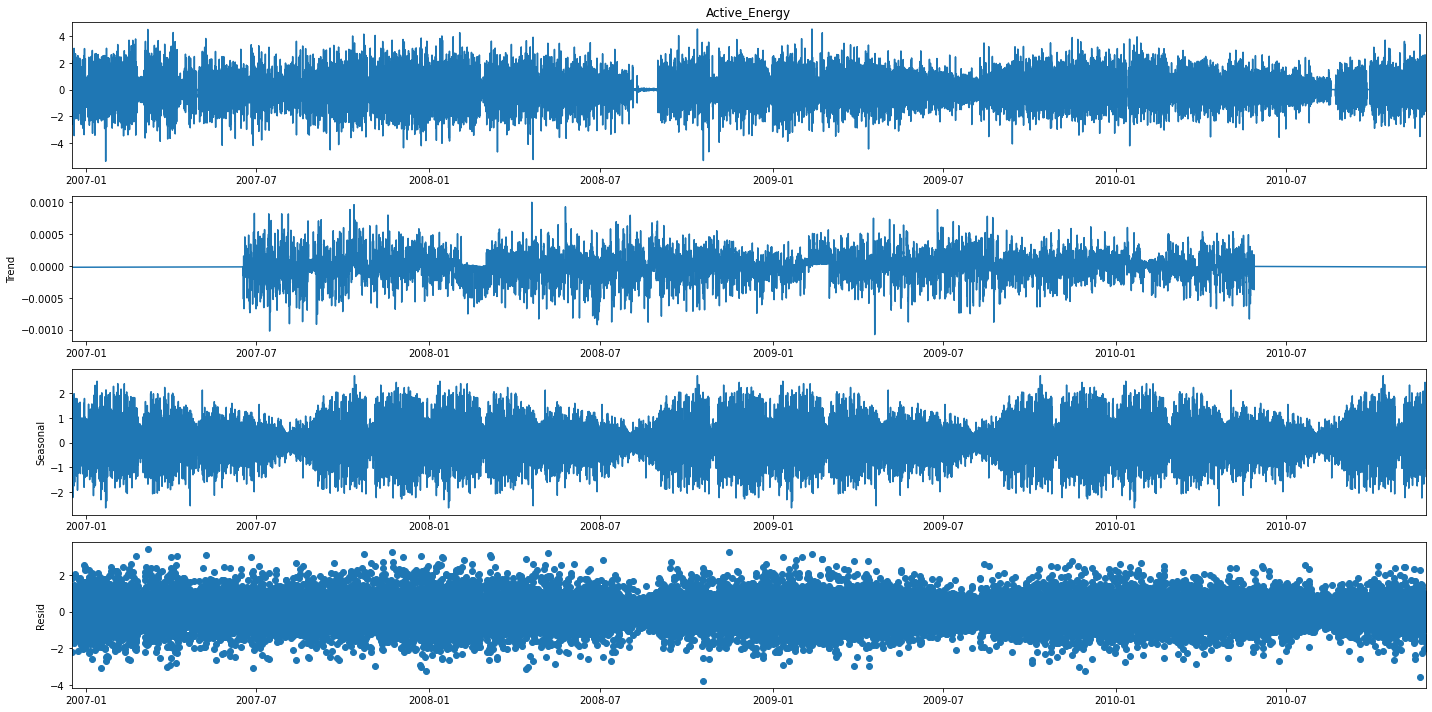

In [92]:
decomposition = seasonal_decompose(diff_2_series['Active_Energy'], model='additive',period=8760, extrapolate_trend='freq')
decomposition.plot()
pyplot.show()

In [93]:
ADFuller(diff_2_series['Active_Energy'])

ADF Statistic: -38.43737080900372
p-value: 0.0
Critial Values:
   1%, -3.430539372390638
Critial Values:
   5%, -2.8616236978814324
Critial Values:
   10%, -2.5668145497579236
Result: The series is stationary


In [94]:
kpss_test(diff_2_series['Active_Energy'])

KPSS Statistic: 0.0018806339581543348
p-value: 0.1
num lags: 52
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\Amin y Lubna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Amin y Lubna\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


We can see that a second differentation doesn't improve much the time series.

# Autocorrelation

Autocorrelation is the relation betwenn the value at present time and the lagged values.

In [95]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

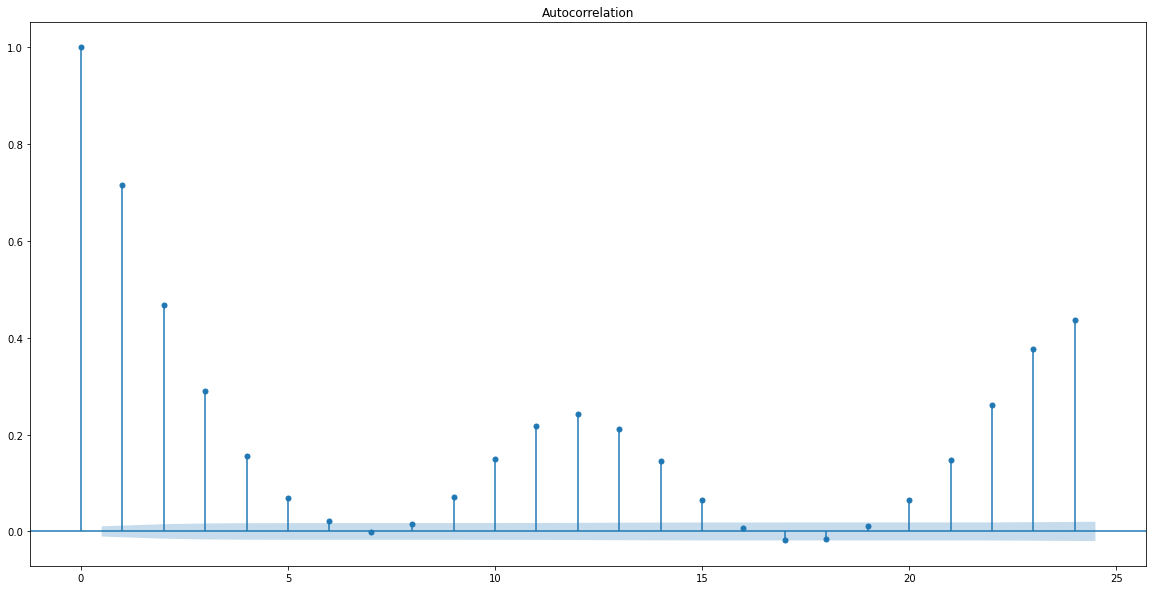

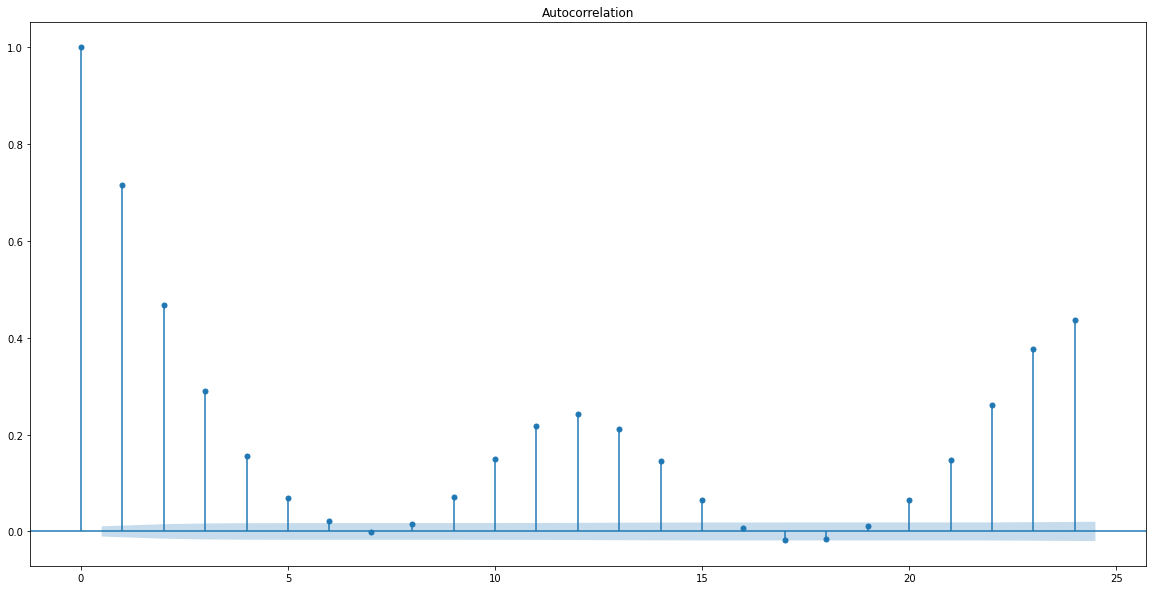

In [96]:
lag=24
plot_acf(power_consumption['Active_Energy'],lags=lag )

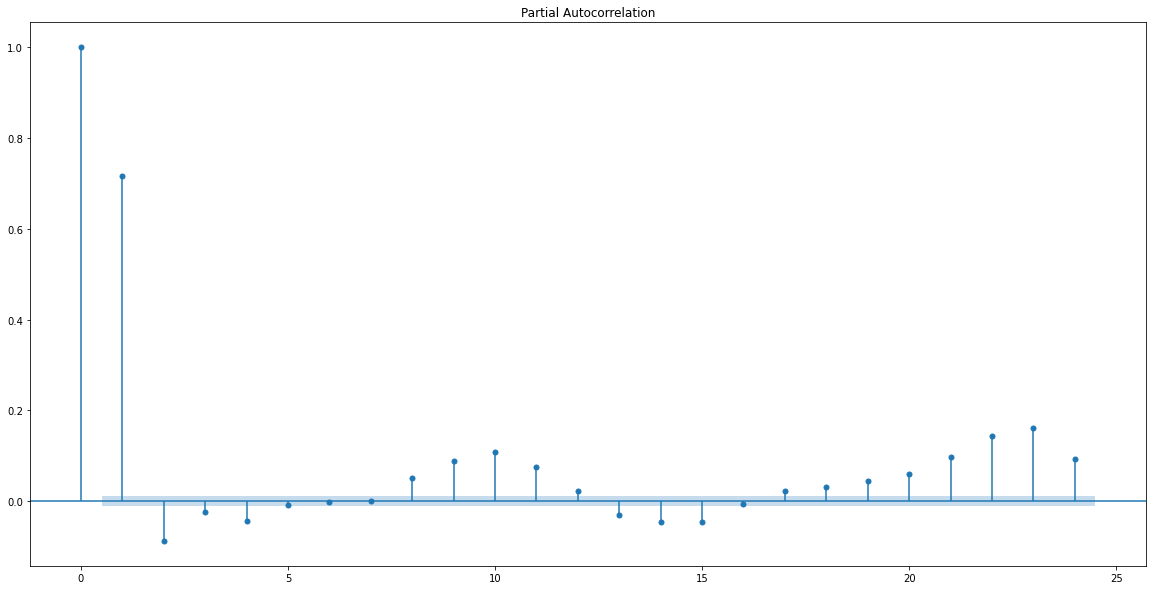

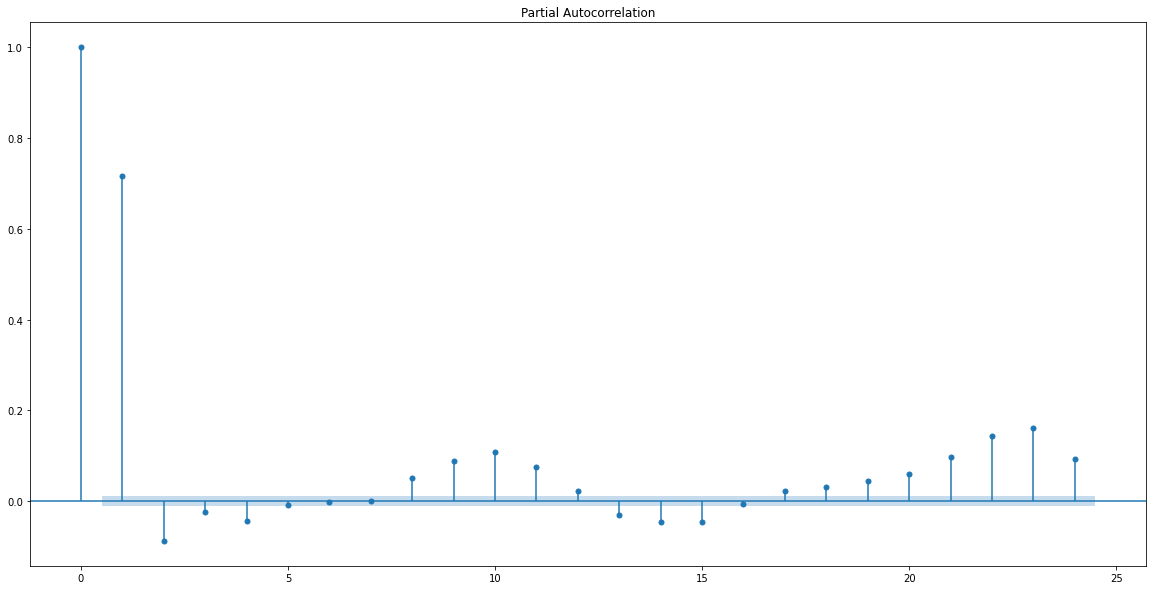

In [97]:
plot_pacf(power_consumption['Active_Energy'],lags=lag )

Once again, the autocorrelation plots show a seasonal pattern. In the plots we can see a peak at 12 lag and another one at 24.
So we have, 2 seasonality in a day frequency and we have another one on the year frequency.
Those multiple seasonality will make hard the forecasting.

# Model Building

After the EDA we have an idea of how our data is:
We saw the presence of multiple seasonality, and therefore the series is non-stationary.
We saw that there is no trend.
We saw that the series is sparse (common in utilitys).
We saw that the series follows a beta type distribution.

To start, we will use a simple Seasonal Naive Forecast to get a benchmark, that will use to compare the models we are going to 
fit to the data.
The Seasonal Naive Forecast, will take the value of the last year and use that as forecast.

In [122]:
def seasonal_naive_forecast(data,forecast_step):
    forecast=np.zeros(forecast_step)
    for i in range(forecast_step):
        forecast[i]=data.at[data.index[-1-i]-pd.DateOffset(years=1), 'Active_Energy'] 
    return np.flipud(forecast)

In [123]:
def plot_comparative_graph(actual,forecast):
    plt.pyplot.plot(actual,marker='.',label='Reales')
    plt.pyplot.plot(forecast,'r',label='Prediccion')
    plt.pyplot.legend()

In [124]:
def seasonal_naive_results(data,train_size):
    train=data[:int(np.ceil(len(data)*train_size))]
    test=data[int(np.ceil(len(data)*train_size)):]
    forecast=seasonal_naive_forecast(data,len(test))
    actual=np.array(test)
    history=np.array(train)
    score=np.sqrt(mean_squared_error(actual, forecast))
    plot_comparative_graph(actual,forecast)
    return score

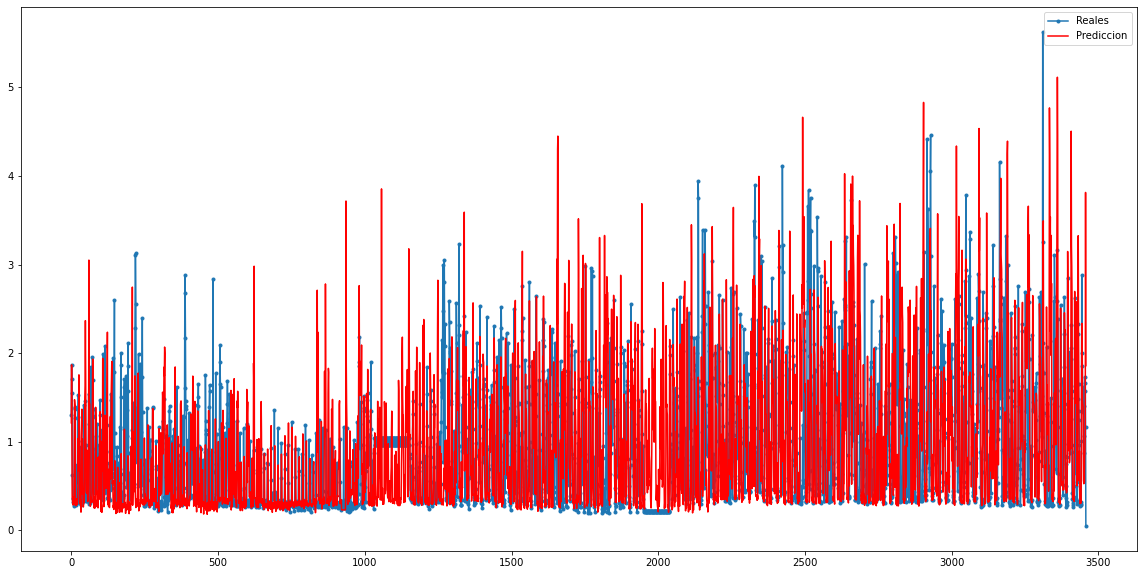

In [125]:
benchmark=seasonal_naive_results(power_consumption,.9)

In [126]:
benchmark

0.8167520987482778

 Now, that we have a benchmark with a simple model, we can start to test more complex algorithm. As validation method we will use 
a rolling window.

We will set the forecast step to be 24 (1 day) and we set the window_size to be 240 (10 day)

In [127]:
forecast_step=24
window_size=240

# Holt-Winter

The next model, we will use is from the Exponential Smothing family. We will use the Holt-Winter method because it can handle trend and seasonality. And as we had shown the series has seasonality.

In [128]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [195]:
def HW_forecast(data,forecast_step):
    data=np.array(data)
    model = ExponentialSmoothing(data.flatten(),trend=None,seasonal='add',seasonal_periods=12,initialization_method='estimated',use_boxcox=True).fit()
    return model.forecast(forecast_step)

In [196]:
def evaluate_model(train,test,model,forecast_step,window_size):
    history = [x for x in train]
    forecast= list()
    for i in range(len(test)):
        y_pred=model(history[:window_size],forecast_step)
        forecast.append(y_pred)
        history.append(test[i])
    rmse=np.sqrt(mean_squared_error(forecast,test))
    forecast=np.array(forecast)
    return rmse,forecast  

We take the first 7 rows and the last 22 to get a time series only with complete days.
Then we split the data in groups of 24, so we have array with the energy consumption per day, it will make easier handle the data

In [197]:
power_consumption_HW=power_consumption['Active_Energy'].copy()
power_consumption_HW.drop(power_consumption_HW.index[:7],inplace=True)
power_consumption_HW.drop(power_consumption_HW.index[-22:],inplace=True)
train=power_consumption_HW[:window_size]
test=power_consumption_HW[window_size:]
train = np.array(np.split(train, len(train)/(24)))
test = np.array(np.split(test, len(test)/(24)))

In [198]:
score_HW,prediction_HW=evaluate_model(train,test,HW_forecast,forecast_step,window_size)

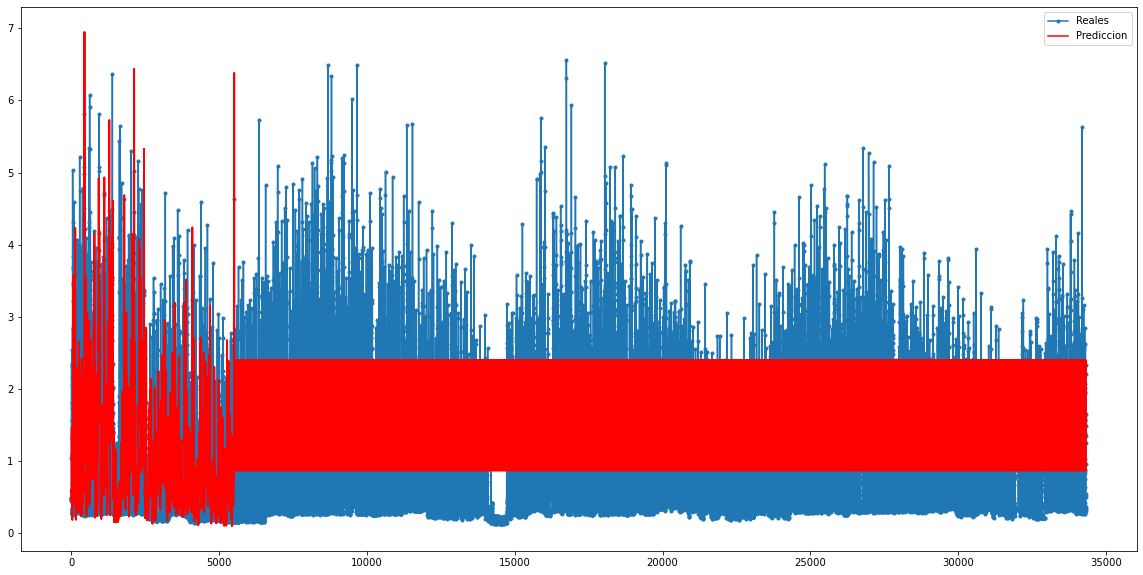

In [199]:
plt.pyplot.plot(actual.flatten(),marker='.',label='Reales')
plt.pyplot.plot(prediction_HW.flatten(),'r',label='Prediccion')
plt.pyplot.legend()

In [ ]:
score

# SARIMA

After having the tried the Holt-Winter method, we are going to try the well-known and widely used ARIMA family. Has we had seen before our data has seasonality so ARIMA won't work because it can't handle seasonality. So, we will use SARIMA (seasonal ARIMA) which id not ideal neither because as we had shown during the data analysis, the series has multiple seasonality and the SARIMA is made to handle simple seasonality.

There is a no well-established method to infer the SARIMA hyperparameters. We could use the PACF and ACF plot to infer the P and Q, but because of the seasonality of the data using PACF and ACF as criteria won't show the best results.
On the other hand, we could inffer the hyperparameter D, by the number of differentiation we had to do to get a stationary series, in our case 1.

Because of all the above we are going to do a grid search and we will get as our model the one that has the lowest AIC (Akaike
Information Criterion)
To do that we are going to use pmdarima library.